# Analysis Extension for OST
## Gait Quality Analysis

**Student Name:** Bakhtiyor Sohibnazarov   
**Student ID:** Z22590018   
**Module:** Final Year Project   
**Updated:** 12th December 2025 

This notebook:

1. Detects heel strikes and computes basic gait metrics (cadence, step length, etc.).
2. Produces compact, explainable summaries and a small set of diagnostic plots.

In [10]:
# Install necessary libraries
!pip -q install pandas numpy

In [11]:
# ============================================================
# 1. IMPORTS & GLOBAL CONFIGURATION
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from math import sqrt

# ------------------------------------------------------------
# File paths 
# ------------------------------------------------------------
INPUT_CSV_RAW          = "data/28.11_raw.csv"
OUTPUT_CSV_FILTERED    = "output/28.11_filtered.csv"
OUTPUT_CSV_REDUCED     = "output/28.11_preprocessed.csv"

# ------------------------------------------------------------
# Heel-strike detection
# ------------------------------------------------------------
LEFT_HEEL_INDEX        = 29
RIGHT_HEEL_INDEX       = 30
MIN_PEAK_DISTANCE_SEC  = 0.40   # minimum time between heel strikes (same leg)
PEAK_PROMINENCE        = 0.001  # minima depth threshold (after inversion)


## 1. Heel-strike detection and gait metrics

We now:
1. Use filtered, reduced data.
2. Take left and right heel vertical positions.
3. Detect heel strikes as local minima (peaks in `-heel_y`).
4. Compute:
   - Number of heel strikes per leg
   - Cadence (steps per minute)
   - Step times
   - Forward step length (using Z-coordinate difference at heel strikes)
5. Summarise metrics in a compact table.


In [18]:
###### ============================================================
# 7. HEEL-STRIKE DETECTION & GAIT METRICS
# ============================================================

print_section("Heel-strike detection & gait metrics")

df = final_reduced.copy()
time = df["time"].to_numpy()
dt = np.median(np.diff(time))
fps_est = 1.0 / dt

mask_valid = df["valid"].to_numpy()

def joint_xyz(j_idx):
    return get_joint_array(df, j_idx, mask=mask_valid)

L_heel = joint_xyz(LEFT_HEEL_INDEX)
R_heel = joint_xyz(RIGHT_HEEL_INDEX)

L_heel_y = L_heel[:, 1]
R_heel_y = R_heel[:, 1]

# --- 7.1 Detect heel strikes as minima in heel Y (peaks in -Y) ---
min_dist_frames = max(1, int(MIN_PEAK_DISTANCE_SEC * fps_est))

inv_L = -L_heel_y
inv_R = -R_heel_y

L_peaks, _ = find_peaks(inv_L, distance=min_dist_frames, prominence=PEAK_PROMINENCE)
R_peaks, _ = find_peaks(inv_R, distance=min_dist_frames, prominence=PEAK_PROMINENCE)

L_strike_t = time[mask_valid][L_peaks]
R_strike_t = time[mask_valid][R_peaks]

print(f"Left heel strikes detected:  {len(L_peaks)}")
print(f"Right heel strikes detected: {len(R_peaks)}")

# --- 7.2 Cadence & step times ---
def step_times(strike_t):
    if len(strike_t) < 2:
        return np.array([])
    return np.diff(strike_t)

L_step_times = step_times(L_strike_t)
R_step_times = step_times(R_strike_t)

def cadence_from_step_times(step_t):
    if len(step_t) == 0:
        return np.nan
    mean_step = np.mean(step_t)
    # 1 step per step time → convert to steps per minute
    return 60.0 / mean_step

L_cadence = cadence_from_step_times(L_step_times)
R_cadence = cadence_from_step_times(R_step_times)

# --- 7.3 Step length (using forward Z distance between consecutive strikes) ---

L_heel_z = L_heel[:, 2]
R_heel_z = R_heel[:, 2]

# Helper: sample Z at strike indices in valid-mask space
valid_indices = np.where(mask_valid)[0]
L_valid_idx = valid_indices[L_peaks]
R_valid_idx = valid_indices[R_peaks]

L_strike_z = L_heel_z[L_peaks]
R_strike_z = R_heel_z[R_peaks]

# Simplest definition: forward progression between consecutive strikes of same leg
def step_lengths(strike_idx, z_values):
    if len(strike_idx) < 2:
        return np.array([])
    # difference in z between consecutive strikes
    return np.diff(z_values)

L_step_len = step_lengths(L_valid_idx, L_strike_z)
R_step_len = step_lengths(R_valid_idx, R_strike_z)

# --- 7.4 Summarise metrics ---
def summarize_array(name, arr):
    arr = np.asarray(arr)
    if arr.size == 0:
        return {f"{name}_mean": np.nan, f"{name}_std": np.nan}
    return {
        f"{name}_mean": float(np.mean(arr)),
        f"{name}_std":  float(np.std(arr))
    }

metrics = {
    "fps_est": fps_est,
    "n_L_strikes": len(L_peaks),
    "n_R_strikes": len(R_peaks),
    "cadence_L_steps_min": L_cadence,
    "cadence_R_steps_min": R_cadence,
}
metrics.update(summarize_array("L_step_time_s", L_step_times))
metrics.update(summarize_array("R_step_time_s", R_step_times))
metrics.update(summarize_array("L_step_len_z", L_step_len))
metrics.update(summarize_array("R_step_len_z", R_step_len))

metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])
display(metrics_df.style.set_caption("Gait Metrics Summary"))



Heel-strike detection & gait metrics
Left heel strikes detected:  2257
Right heel strikes detected: 2341


,Value
fps_est,15.035559
n_L_strikes,2257.000000
n_R_strikes,2341.000000
cadence_L_steps_min,77.027137
cadence_R_steps_min,79.889668
L_step_time_s_mean,0.778946
L_step_time_s_std,0.106758
R_step_time_s_mean,0.751036
R_step_time_s_std,0.130580
L_step_len_z_mean,0.000007


## 8. Compact visual diagnostics

We keep plots minimal and meaningful:

1. Left & right heel trajectories with detected strikes.
2. Step length over time (for both legs).



Plotting diagnostics


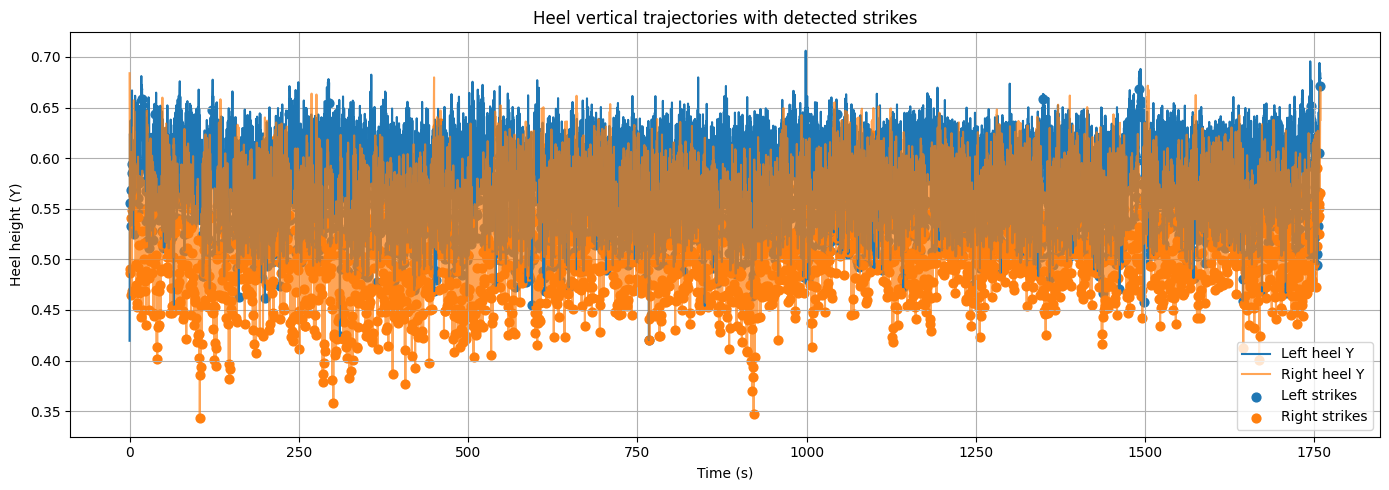

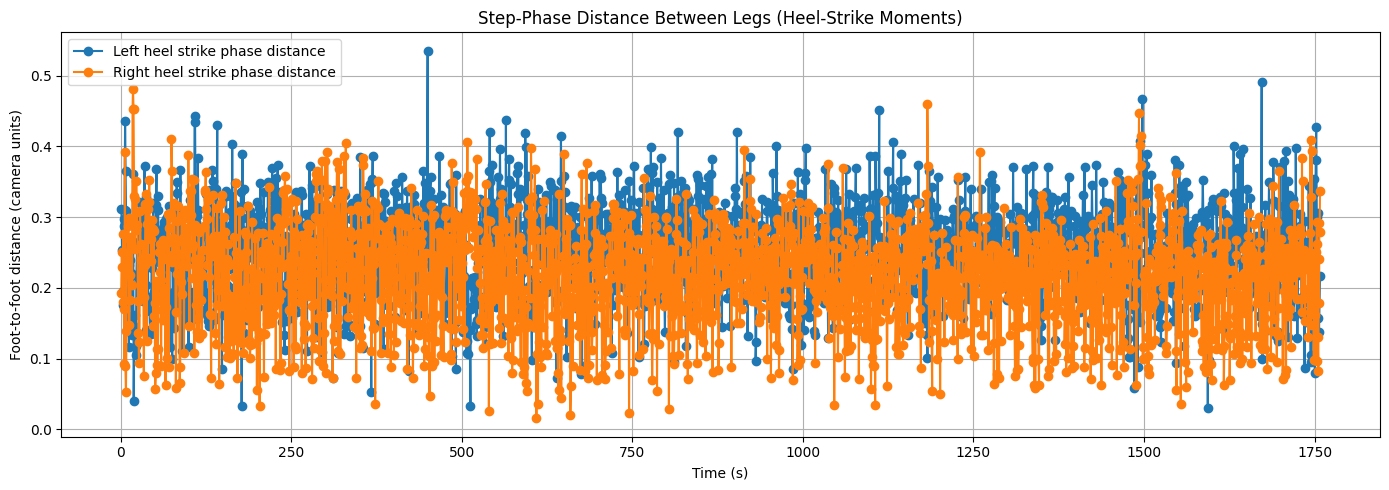


Step-Phase Distance Summary
LEFT heel-strike step-phase distance:
  Steps: 2257
  Mean distance: 0.2520
  Std deviation: 0.0626
  Min distance: 0.0294
  Max distance: 0.5352

RIGHT heel-strike step-phase distance:
  Steps: 2341
  Mean distance: 0.2179
  Std deviation: 0.0700
  Min distance: 0.0155
  Max distance: 0.4807

Symmetry Index:
  0.1449  (0 = perfect symmetry)
  Positive = Left steps have larger separation; Negative = Right steps larger

First 10 L-step distances: [0.312  0.2532 0.1758 0.1954 0.2873 0.2969 0.3094 0.4351 0.3653 0.3083]
First 10 R-step distances: [0.1929 0.2511 0.2298 0.1793 0.2763 0.1706 0.092  0.3922 0.0888 0.0525]


In [19]:
# ============================================================
# 8. PLOTS: HEEL TRAJECTORIES & STEP LENGTHS
# ============================================================

print_section("Plotting diagnostics")

# 8.1 Heel Y trajectories
plt.figure(figsize=(14, 5))
plt.plot(time[mask_valid], L_heel_y, label="Left heel Y")
plt.plot(time[mask_valid], R_heel_y, label="Right heel Y", alpha=0.7)
plt.scatter(L_strike_t, L_heel_y[L_peaks], s=40, label="Left strikes")
plt.scatter(R_strike_t, R_heel_y[R_peaks], s=40, label="Right strikes")
plt.xlabel("Time (s)")
plt.ylabel("Heel height (Y)")
plt.title("Heel vertical trajectories with detected strikes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# Compute 3D distance between feet for each valid frame
# ============================================================

# Heel coordinates already filtered by mask_valid
Lx, Ly, Lz = L_heel[:, 0], L_heel[:, 1], L_heel[:, 2]
Rx, Ry, Rz = R_heel[:, 0], R_heel[:, 1], R_heel[:, 2]

# Euclidean distance in camera 3D space
leg_dist = np.sqrt((Lx - Rx)**2 + (Ly - Ry)**2 + (Lz - Rz)**2)


# 8.2 Distance between legs in camera coordinate system (3D)
# STEP-PHASE DISTANCE (distance between feet at heel strikes)
time_valid = time[mask_valid]
# Distances at heel-strike moments
L_step_phase = leg_dist[L_peaks]
R_step_phase = leg_dist[R_peaks]

L_step_t = time_valid[L_peaks]
R_step_t = time_valid[R_peaks]

plt.figure(figsize=(14,5))

plt.plot(L_step_t, L_step_phase, "o-", label="Left heel strike phase distance")
plt.plot(R_step_t, R_step_phase, "o-", label="Right heel strike phase distance")

plt.xlabel("Time (s)")
plt.ylabel("Foot-to-foot distance (camera units)")
plt.title("Step-Phase Distance Between Legs (Heel-Strike Moments)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# Step-Phase Distance Summary (Text Output)
# ============================================================

print_section("Step-Phase Distance Summary")

def summarize_step_phase(name, arr):
    return {
        "count": len(arr),
        "mean": np.mean(arr) if len(arr) > 0 else np.nan,
        "std": np.std(arr) if len(arr) > 0 else np.nan,
        "min": np.min(arr) if len(arr) > 0 else np.nan,
        "max": np.max(arr) if len(arr) > 0 else np.nan,
    }

L_stats = summarize_step_phase("Left", L_step_phase)
R_stats = summarize_step_phase("Right", R_step_phase)

# Symmetry index (0 = perfect symmetry)
sym_index = (L_stats["mean"] - R_stats["mean"]) / ((L_stats["mean"] + R_stats["mean"]) / 2)

print("LEFT heel-strike step-phase distance:")
print(f"  Steps: {L_stats['count']}")
print(f"  Mean distance: {L_stats['mean']:.4f}")
print(f"  Std deviation: {L_stats['std']:.4f}")
print(f"  Min distance: {L_stats['min']:.4f}")
print(f"  Max distance: {L_stats['max']:.4f}")

print("\nRIGHT heel-strike step-phase distance:")
print(f"  Steps: {R_stats['count']}")
print(f"  Mean distance: {R_stats['mean']:.4f}")
print(f"  Std deviation: {R_stats['std']:.4f}")
print(f"  Min distance: {R_stats['min']:.4f}")
print(f"  Max distance: {R_stats['max']:.4f}")

print("\nSymmetry Index:")
print(f"  {sym_index:.4f}  (0 = perfect symmetry)")
print("  Positive = Left steps have larger separation; Negative = Right steps larger")

# Optional: print first few values for quick eyeballing
print("\nFirst 10 L-step distances:", np.round(L_step_phase[:10], 4))
print("First 10 R-step distances:", np.round(R_step_phase[:10], 4))

## Joint Angle Calculations


Joint angle calculations (hip & knee)


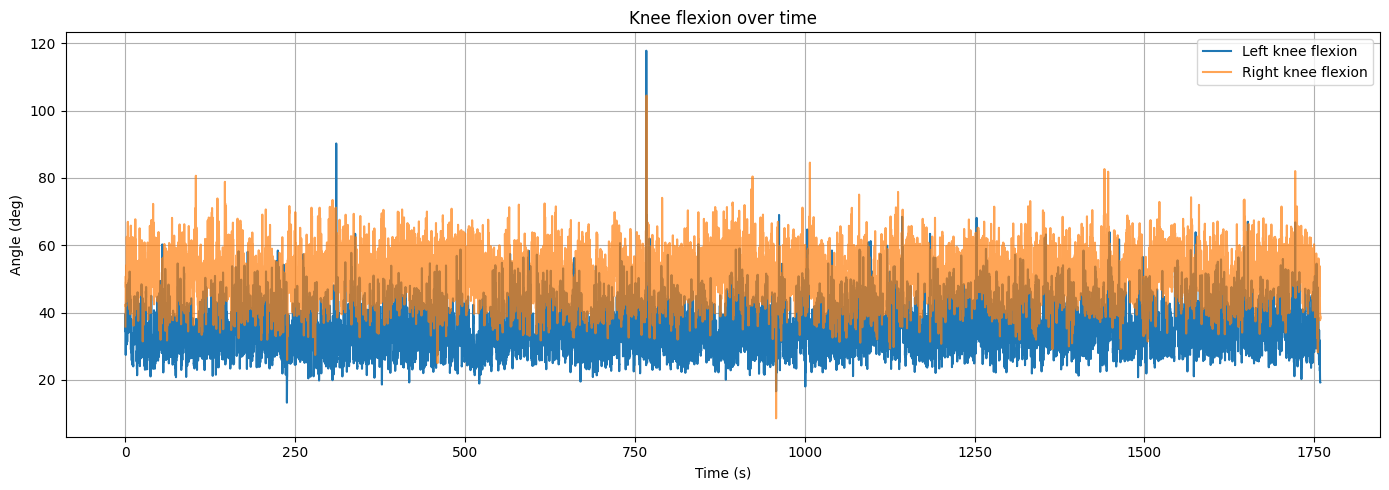

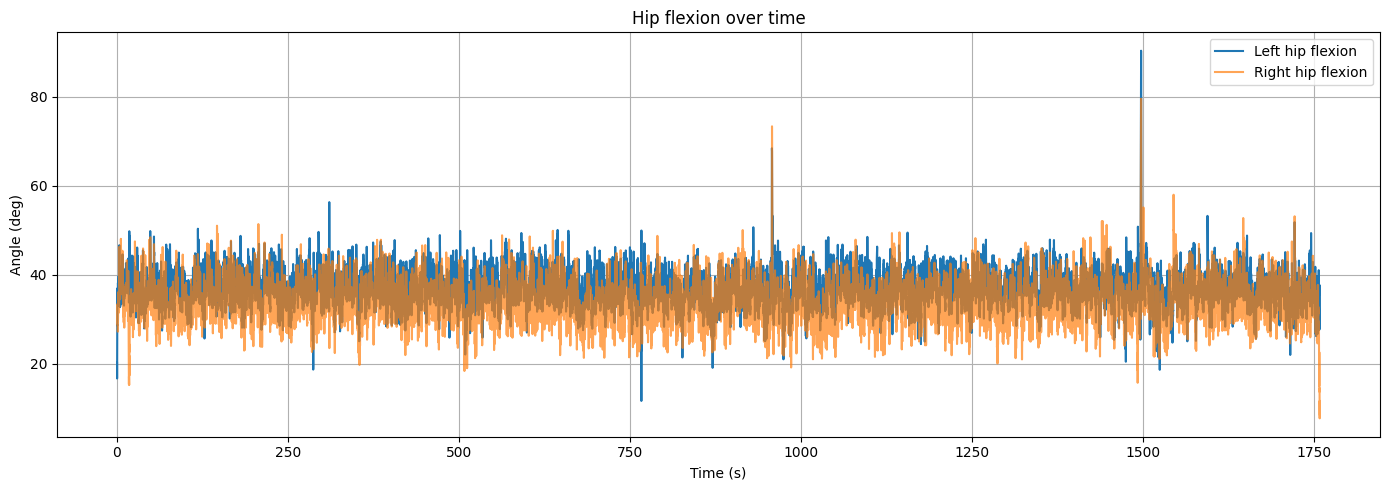


Joint angle summary
Left knee flexion:
  Mean: 35.2°
  Min:  13.3°
  Max:  117.8°
  ROM:  104.5°

Right knee flexion:
  Mean: 50.4°
  Min:  8.6°
  Max:  104.5°
  ROM:  95.8°

Left hip flexion:
  Mean: 37.2°
  Min:  11.6°
  Max:  90.4°
  ROM:  78.8°

Right hip flexion:
  Mean: 33.2°
  Min:  7.7°
  Max:  79.6°
  ROM:  71.9°



In [20]:
# ============================================================
# 10. JOINT ANGLES: HIP & KNEE
# ============================================================

print_section("Joint angle calculations (hip & knee)")

df = final_reduced.copy()
time = df["time"].to_numpy()
mask_valid = df["valid"].to_numpy()
t_valid = time[mask_valid]

def joint_series(j_idx):
    """N_valid x 3 array for joint j_idx on valid frames."""
    return get_joint_array(df, j_idx, mask=mask_valid)

# ---- Get joint coordinates ----
L_hip    = joint_series(23)
R_hip    = joint_series(24)
L_knee   = joint_series(25)
R_knee   = joint_series(26)
L_ankle  = joint_series(27)
R_ankle  = joint_series(28)
L_shldr  = joint_series(11)
R_shldr  = joint_series(12)

def angle_series(proximal, joint, distal):
    """
    Returns angle at 'joint' in degrees for each frame.
    proximal - joint - distal  (three N x 3 arrays)
    Geometric angle between the two bone segments.
    """
    v1 = proximal - joint
    v2 = distal   - joint

    # norms
    n1 = np.linalg.norm(v1, axis=1)
    n2 = np.linalg.norm(v2, axis=1)

    # avoid divide-by-zero
    eps = 1e-8
    n1 = np.where(n1 < eps, eps, n1)
    n2 = np.where(n2 < eps, eps, n2)

    dot = np.einsum("ij,ij->i", v1, v2)
    cosang = dot / (n1 * n2)
    cosang = np.clip(cosang, -1.0, 1.0)

    return np.degrees(np.arccos(cosang))  # 0..180°

# ---- Knee flexion angles ----
L_knee_angle_geom = angle_series(L_hip,  L_knee, L_ankle)
R_knee_angle_geom = angle_series(R_hip,  R_knee, R_ankle)

# Optional convention: 0° = full extension, >0 = flexion
# If you want that, do:
L_knee_flex = 180.0 - L_knee_angle_geom
R_knee_flex = 180.0 - R_knee_angle_geom

# ---- Hip flexion angles (shoulder–hip–knee) ----
# Correct hip flexion using thigh vector vs vertical axis
vertical = np.array([0, 1, 0])  # Y is height

def angle_with_vertical(v):
    v_norm = v / (np.linalg.norm(v, axis=1, keepdims=True) + 1e-9)
    dot = np.einsum("ij,j->i", v_norm, vertical)
    dot = np.clip(dot, -1, 1)
    return np.degrees(np.arccos(dot))

# Thigh vectors
L_thigh = L_knee - L_hip
R_thigh = R_knee - R_hip

L_hip_flex = angle_with_vertical(L_thigh)
R_hip_flex = angle_with_vertical(R_thigh)


# ------------------------------------------------------------
# Plot knee flexion over time
# ------------------------------------------------------------
plt.figure(figsize=(14,5))
plt.plot(t_valid, L_knee_flex, label="Left knee flexion")
plt.plot(t_valid, R_knee_flex, label="Right knee flexion", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Knee flexion over time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot hip flexion over time
# ------------------------------------------------------------
plt.figure(figsize=(14,5))
plt.plot(t_valid, L_hip_flex, label="Left hip flexion")
plt.plot(t_valid, R_hip_flex, label="Right hip flexion", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Hip flexion over time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# Joint angle summary (ROM etc.)
# ============================================================

print_section("Joint angle summary")

def summarize_angle(name, arr):
    arr = np.asarray(arr)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        print(f"{name}: no data")
        return
    mean = np.mean(arr)
    amin = np.min(arr)
    amax = np.max(arr)
    rom  = amax - amin
    print(f"{name}:")
    print(f"  Mean: {mean:.1f}°")
    print(f"  Min:  {amin:.1f}°")
    print(f"  Max:  {amax:.1f}°")
    print(f"  ROM:  {rom:.1f}°\n")

summarize_angle("Left knee flexion",  L_knee_flex)
summarize_angle("Right knee flexion", R_knee_flex)
summarize_angle("Left hip flexion",   L_hip_flex)
summarize_angle("Right hip flexion",  R_hip_flex)


Trend slope: 9.361611217121297e-06
Step frequency is increasing over time.


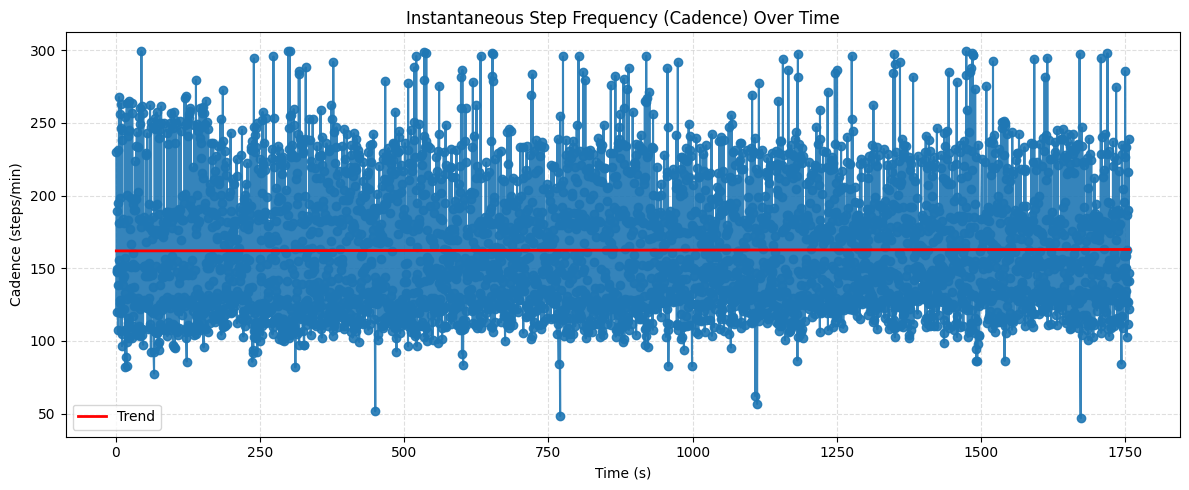

In [25]:
# Combine left + right heel strikes
all_peaks = np.unique(np.sort(np.concatenate([L_peaks, R_peaks])))

# timestamps at peaks
peak_times = time[all_peaks]

# raw step times
raw_step_times = np.diff(peak_times)

# keep only realistic steps (0.2s–1.5s = 40–300 steps/min)
mask = (raw_step_times > 0.2) & (raw_step_times < 1.5)
step_times = raw_step_times[mask]
step_timestamps = peak_times[1:][mask]   # ← correct timestamps

# Instantaneous step frequency (Hz)
step_freq = 1.0 / step_times

# Cadence (steps/min)
cadence_inst = step_freq * 60

# Build step dataframe (aligned!)
df_steps = pd.DataFrame({
    "time": step_timestamps,
    "step_time": step_times,
    "step_freq_hz": step_freq,
    "cadence_spm": cadence_inst
})

df_steps

# Trend line
coef = np.polyfit(df_steps["time"], df_steps["step_freq_hz"], 1)
trend = coef[0]

print("Trend slope:", trend)
if trend > 0:
    print("Step frequency is increasing over time.")
else:
    print("Step frequency is stable or decreasing.")


plt.figure(figsize=(12, 5))

plt.plot(df_steps["time"], df_steps["cadence_spm"], marker='o', linestyle='-', alpha=0.9)

plt.title("Instantaneous Step Frequency (Cadence) Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Cadence (steps/min)")

plt.grid(True, linestyle='--', alpha=0.4)

# Optional: Plot a trend line
coef = np.polyfit(df_steps["time"], df_steps["cadence_spm"], 1)
trend_line = np.polyval(coef, df_steps["time"])
plt.plot(df_steps["time"], trend_line, color='red', linewidth=2, label="Trend")

plt.legend()
plt.tight_layout()
plt.show()



## Generate Report

In [ ]:
# ============================================================
#               TEXT-ONLY GAIT REPORT PDF EXPORT
# ============================================================

from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
import numpy as np

def safe(v):
    """Safely format values even if missing."""
    try:
        return f"{v:.4f}"
    except:
        return "N/A"

styles = getSampleStyleSheet()
H  = styles["Heading1"]
H2 = styles["Heading2"]
N  = styles["BodyText"]

doc = SimpleDocTemplate("report.pdf", pagesize=A4)
story = []

# ------------------------------------------------------------
# BASIC DATA INFO
# ------------------------------------------------------------
story.append(Paragraph("1. Dataset Information", H))
story.append(Paragraph("Automatically Generated Summary (Text Only)", N))

try:
    story.append(Paragraph(f"Valid frames: {np.sum(mask_valid)}", N))
    story.append(Paragraph(f"Total frames: {len(time)}", N))
except:
    story.append(Paragraph("Frame/valid-mask info unavailable.", N))

try:
    story.append(Paragraph(f"Effective FPS: {fps_effective:.3f}", N))
except:
    pass

story.append(Spacer(1, 0.3*cm))

# ------------------------------------------------------------
# STEP-PHASE METRICS
# ------------------------------------------------------------
story.append(Paragraph("2. Step-Phase Distances", H))

try:
    L_mean = safe(np.mean(L_step_phase))
    R_mean = safe(np.mean(R_step_phase))
    sym = safe((np.mean(L_step_phase) - np.mean(R_step_phase)) / ((np.mean(L_step_phase)+np.mean(R_step_phase))/2))

    story.append(Paragraph(f"Left steps (count): {len(L_step_phase)}", N))
    story.append(Paragraph(f"Right steps (count): {len(R_step_phase)}", N))
    story.append(Paragraph(f"Mean left step-phase distance: {L_mean}", N))
    story.append(Paragraph(f"Mean right step-phase distance: {R_mean}", N))
    story.append(Paragraph(f"Symmetry index: {sym}", N))
except:
    story.append(Paragraph("Step-phase metrics unavailable.", N))

story.append(Spacer(1, 0.3*cm))

# ------------------------------------------------------------
# TEMPORAL METRICS (CADENCE, STEP TIMES)
# ------------------------------------------------------------
story.append(Paragraph("3. Temporal Metrics (Cadence, Step Times)", H))

try:
    story.append(Paragraph(f"Mean left step time: {safe(np.mean(L_step_times))} s", N))
    story.append(Paragraph(f"Mean right step time: {safe(np.mean(R_step_times))} s", N))

    cadence_L = 60 / np.mean(L_step_times)
    cadence_R = 60 / np.mean(R_step_times)
    cadence_mean = (cadence_L + cadence_R) / 2

    story.append(Paragraph(f"Cadence (left): {safe(cadence_L)} steps/min", N))
    story.append(Paragraph(f"Cadence (right): {safe(cadence_R)} steps/min", N))
    story.append(Paragraph(f"Overall cadence: {safe(cadence_mean)} steps/min", N))
except:
    story.append(Paragraph("Temporal metrics unavailable.", N))

story.append(Spacer(1, 0.3*cm))

# ------------------------------------------------------------
# JOINT ANGLES
# ------------------------------------------------------------
story.append(Paragraph("4. Joint Angle Summary (Hip & Knee)", H))

def write_angle_stats(name, arr):
    try:
        mn = safe(np.mean(arr))
        amin = safe(np.min(arr))
        amax = safe(np.max(arr))
        rom = safe(np.max(arr) - np.min(arr))
        story.append(Paragraph(f"{name}: mean={mn}°, min={amin}°, max={amax}°, ROM={rom}°", N))
    except:
        story.append(Paragraph(f"{name}: unavailable", N))

write_angle_stats("Left knee flexion", L_knee_flex)
write_angle_stats("Right knee flexion", R_knee_flex)
write_angle_stats("Left hip flexion", L_hip_flex)
write_angle_stats("Right hip flexion", R_hip_flex)

# ------------------------------------------------------------
# BUILD PDF
# ------------------------------------------------------------
doc.build(story)

print("Completed...")
